# A Python Notebook for some quick Visualizations

We were able to get some interesting, and in some cases _not so useful_ results from just looking at data we have collected. Let's visualize some distributions both on the spatial and non-spatial plane.

This notebook brings some of those random visualizations in a rather unstructured way with limited explanations. The goal is to get a feel for the data and see if we can get some further insights.

In [1]:
# Using pathlib for proper path management
from pathlib import Path

# Optimised data storage
import pyarrow.feather as feather

# Data manipulation
import pandas as pd
import geopandas as gpd
import numpy as np

# Spatial checks
import contextily as ctx

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Images in notebooks (for GitHub publishing)
from IPython.display import Image

Let's get the data first.

In [2]:
charging_stations = gpd.read_feather(Path.joinpath(Path.cwd(), 'data', 'private', 'Charging stations.feather'))

A quick map of charging capacity we a bit of twist: using a log scale.

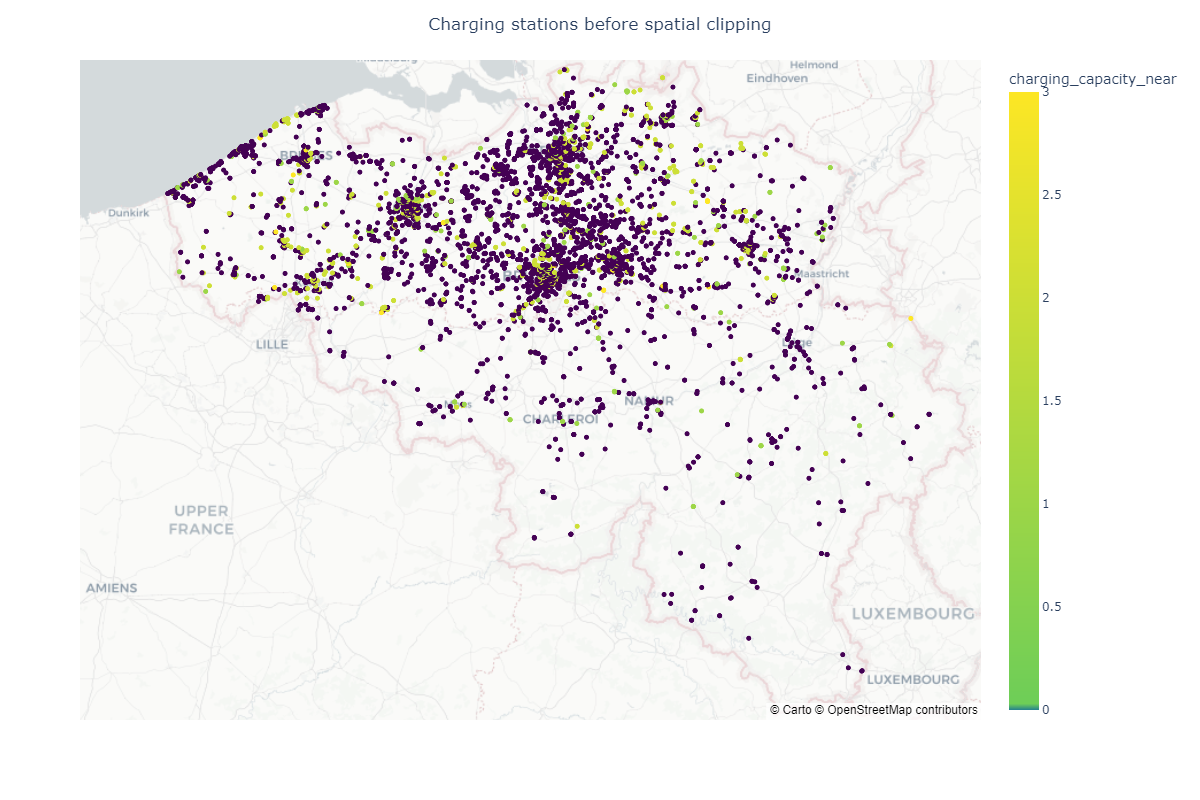

In [3]:
# Need to set my MapBox token
px.set_mapbox_access_token(open(".mapbox_token").read())

# Hint: https://stackoverflow.com/questions/68368745/logarithmic-heatmap-in-plotly
viridis = px.colors.sequential.Viridis
colorscale = [
    [0, viridis[0]],
    [1.0 / 1000000, viridis[2]],
    [1.0 / 10000, viridis[4]],
    [1.0 / 100, viridis[7]],
    [1.0, viridis[9]],
]
colorbar = dict(tick0=0, tickmode="array", tickvals=[0, 1000, 10000])

# Scatter plot of the charging stations
fig = px.scatter_mapbox(
    charging_stations[charging_stations["charging_capacity_near"] < 4],
    lat="latitude",
    lon="longitude",
    hover_name="evse_id",
    color="charging_capacity_near",
    center=dict(lat=50.5, lon=4.3),
    color_discrete_sequence=px.colors.qualitative.Dark24,
    color_continuous_scale = colorscale,
)

fig.update_layout(
    title="Charging stations before spatial clipping",
    title_x=0.5,
    mapbox={
        "style": "carto-positron",
        "zoom": 7.2,
    },
    paper_bgcolor="#ffffff",
    height=800,
    width=1200,
)

# fig.show()
# Instead of Plotly show() we can also take the bytes of the image and display it in the notebook directly using Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)

KDE on the charging sessions dataset

c:\Users\agelanyi\miniconda3\envs\EV\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\agelanyi\miniconda3\envs\EV\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\agelanyi\miniconda3\envs\EV\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\agelanyi\miniconda3\envs\EV\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



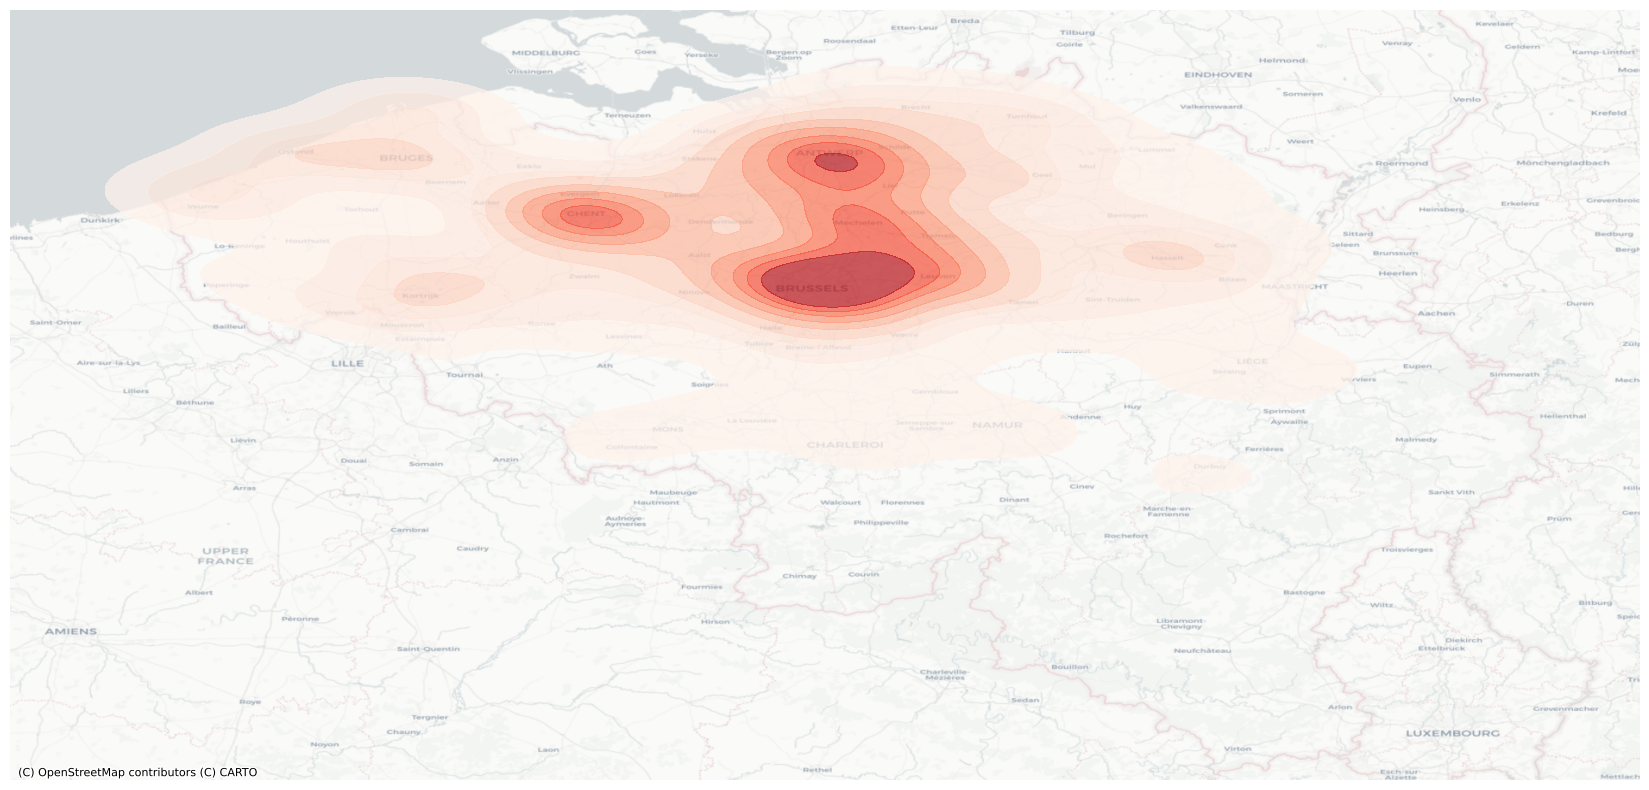

In [4]:
# Create thresholds
levels = [0.2, 0.4, 0.6, 0.8, 1]

# Create plot
f, ax = plt.subplots(ncols=1, figsize=(20, 8))
# Kernel Density Estimation
kde = sns.kdeplot(
    ax=ax,
    x=charging_stations["geometry"].x,
    y=charging_stations["geometry"].y,
    #   levels = levels,
    fill=True,
    cmap="Reds",
    alpha=0.7,
)
# Add a basemap
ctx.add_basemap(
    ax=ax, crs=charging_stations.crs.to_string(), source=ctx.providers.CartoDB.Positron
)
ax.set_axis_off()
plt.tight_layout()

Looking at some descriptive statistics, distributions, etc. of the charging sessions dataset.

In [5]:
charging_sessions_internal = pd.read_feather(Path.joinpath(Path.cwd(), 'data', 'NETWORK_OPERATOR', 'Charging sessions and service records (BBS) BE only.feather'))
charging_sessions_external = pd.read_feather(Path.joinpath(Path.cwd(), 'data', 'NETWORK_OPERATOR', 'Charging sessions (ABS) BE only.feather'))

## Binning session start times for histograms and visualisations

Let's introduce some variables to bin the session start times into different time periods. We will use these variables to create histograms and other visualizations.

In [6]:
# Adding session length and kWh columns
charging_sessions_internal['session_time'] = charging_sessions_internal.end_time - charging_sessions_internal.start_time

charging_sessions_external['session_time'] = charging_sessions_external.time_stopped_session - charging_sessions_external.time_started_session
charging_sessions_external['kWh'] = charging_sessions_external.final_kilo_watt_hour - charging_sessions_external.start_kilo_watt_hour

# Adding time ranges
bins = range(0, 25, 1)
labels = ['0h-1h', '1h-2h', '2h-3h', '3h-4h', '4h-5h', '5h-6h', '6h-7h', '7h-8h', '8h-9h', '9h-10h', '10h-11h', '11h-12h', '12h-13h', '13h-14h', '14h-15h', '15h-16h', '16h-17h', '17h-18h', '18h-19h', '19h-20h', '20h-21h', '21h-22h', '22h-23h', '23h-24h']

# Addings ome binning as per the session start and end times
charging_sessions_internal['start_time_ranges'] = pd.cut(charging_sessions_internal.start_time.dt.hour, bins=bins, labels=labels, right=False)
charging_sessions_internal['end_time_ranges'] = pd.cut(charging_sessions_internal.end_time.dt.hour, bins=bins, labels=labels, right=False)

charging_sessions_external['start_time_ranges'] = pd.cut(charging_sessions_external.time_started_session.dt.hour, bins=bins, labels=labels, right=False)
charging_sessions_external['end_time_ranges'] = pd.cut(charging_sessions_external.time_stopped_session.dt.hour, bins=bins, labels=labels, right=False)

# Adding a column to differentiate between internal and external users
charging_sessions_external['internal_user'] = False

Let's see some exaples from both the internal and external datasets.

In [7]:
# Let's see a few examples
charging_sessions_internal.sample(5, random_state=42)[['start_time', 'end_time', 'session_time', 'start_time_ranges', 'end_time_ranges', 'kWh', 'internal_user']]

,start_time,end_time,session_time,start_time_ranges,end_time_ranges,kWh,internal_user
22160,2022-10-03 11:26:46,2022-10-03 18:33:45,0 days 07:06:59,11h-12h,18h-19h,23.680,True
52446,2022-12-31 11:59:08,2023-01-01 17:18:41,1 days 05:19:33,11h-12h,17h-18h,8.990,True
29702,2022-11-22 00:44:51,2022-11-22 15:31:47,0 days 14:46:56,0h-1h,15h-16h,34.150,True
19449,2022-09-10 20:41:36,2022-09-11 10:11:19,0 days 13:29:43,20h-21h,10h-11h,65.626,True
7919,2022-05-14 12:46:06,2022-05-14 16:04:16,0 days 03:18:10,12h-13h,16h-17h,26.289,True


In [8]:
# Let's see a few examples
charging_sessions_external.sample(5, random_state=42)[['time_started_session', 'time_stopped_session', 'session_time', 'start_time_ranges', 'end_time_ranges', 'kWh', 'internal_user']]

,time_started_session,time_stopped_session,session_time,start_time_ranges,end_time_ranges,kWh,internal_user
17584,2022-04-21 11:33:26,2022-04-21 12:07:43,0 days 00:34:17,11h-12h,12h-13h,1.890,False
61810,2022-08-31 17:16:36,2022-08-31 19:46:26,0 days 02:29:50,17h-18h,19h-20h,5.411,False
55339,2022-08-15 13:17:15,2022-08-18 13:17:11,2 days 23:59:56,13h-14h,13h-14h,0.000,False
105089,2022-11-25 14:06:41,2022-11-25 15:10:13,0 days 01:03:32,14h-15h,15h-16h,3.781,False
79810,2022-10-11 11:53:58,2022-10-11 17:10:04,0 days 05:16:06,11h-12h,17h-18h,9.714,False


We can now use these variables to create a plot of probability density distributions of the start and end time of the combines data.

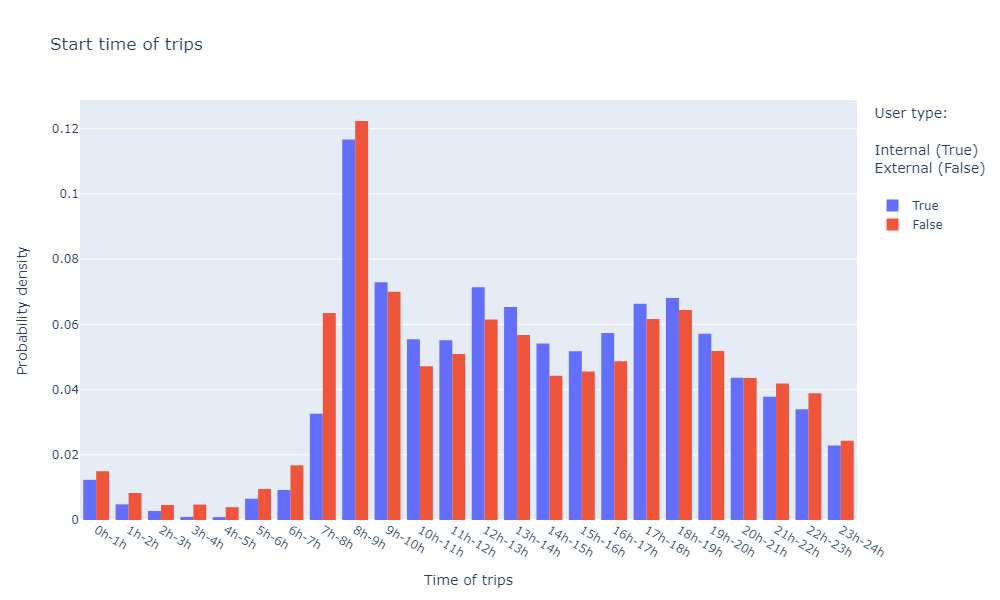

In [9]:
charging_sessions_external.rename(columns={'time_started_session': 'start_time', 'time_stopped_session': 'end_time'}, inplace=True)
charging_sessions = pd.concat([charging_sessions_internal, charging_sessions_external])

fig = px.histogram(
    charging_sessions,
    x="start_time_ranges",
    color="internal_user",
    barmode="group",
    title="Start time of trips",
    #histnorm="percent",
    histnorm='probability density',
    #text_auto=True,
    labels={"internal_user": "User type:<br><br>Internal (True)<br>External (False)<br>"},
    height=600, width=1000,
)
fig.update_xaxes(categoryorder="array", categoryarray=labels, title='Time of trips')
fig.update_yaxes(title='Probability density')

#fig.show()
# Instead of Plotly show() we can also take the bytes of the image and display it in the notebook directly using Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)

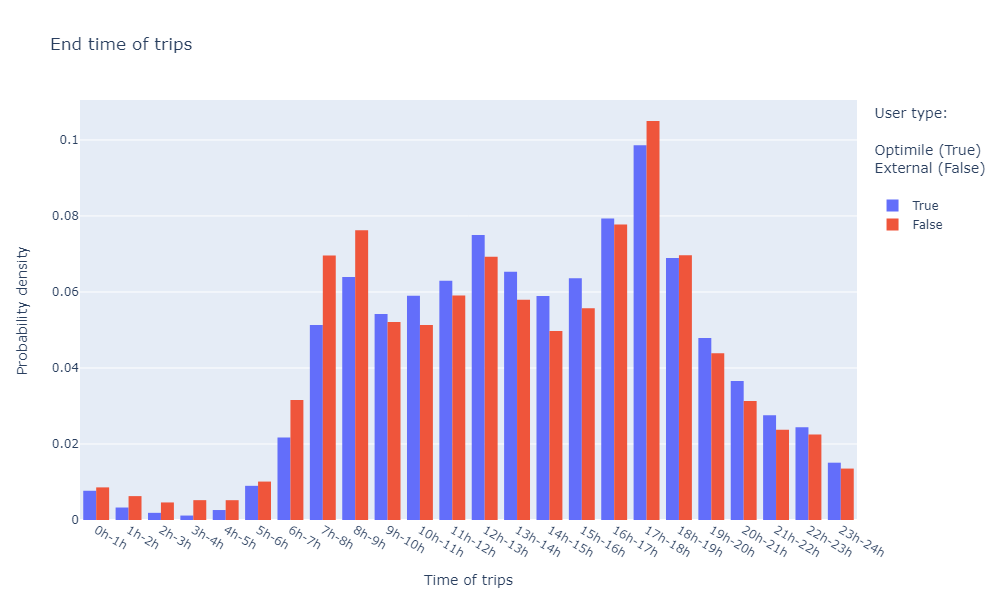

In [10]:
fig = px.histogram(
    charging_sessions,
    x="end_time_ranges",
    color="internal_user",
    barmode="group",
    title="End time of trips",
    #histnorm="percent",
    histnorm='probability density',
    #text_auto=True,
    labels={"internal_user": "User type:<br><br>Internal (True)<br>External (False)<br>"},
    height=600, width=1000,
    )
fig.update_xaxes(categoryorder="array", categoryarray=labels, title='Time of trips')
fig.update_yaxes(title='Probability density')

#fig.show()
# Instead of Plotly show() we can also take the bytes of the image and display it in the notebook directly using Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)

Now, we can check the spatial distribution of the charging sessions.

In [11]:
charging_sessions['latitude'].isna().sum()
charging_sessions['longitude'].isna().sum()

0

Okay, we are good to go...

We are getting some information about Belgian administrative regions, then generating some maps for visualizing the distribution and location of charging sessions.

In [12]:
import geopandas as gpd

# Loading the shapefile describing administrative regions in Belgium
belgium_adm2 = gpd.read_file(Path.joinpath(Path.cwd(), "data", "UC", "BEL_adm2.shp"))
belgium_adm2.to_crs("EPSG:4326", inplace=True)

charging_sessions_gdf = gpd.GeoDataFrame(
    data=charging_sessions,
    geometry=gpd.points_from_xy(
        charging_sessions.longitude, charging_sessions.latitude
    ),
    crs="EPSG:4326",
)

# Let's create a new column with the region name using spatial joins
charging_sessions_regions = gpd.sjoin(charging_sessions_gdf, belgium_adm2, how="left", predicate='within')


In [13]:
# We'll need the representation of start time in seconds
charging_sessions_regions['start_time_seconds'] = charging_sessions_regions.start_time.dt.hour * 3600 + charging_sessions_regions.start_time.dt.minute * 60 + charging_sessions_regions.start_time.dt.second

# So, let's make things simple: morning is before 12:00pm and evening is after 12:00pm
charging_sessions_regions['start_time_seconds_morning'] = charging_sessions_regions.apply(lambda row: row['start_time_seconds'] if row['start_time_seconds'] < 43200 else None, axis=1)
charging_sessions_regions['start_time_seconds_evening'] = charging_sessions_regions.apply(lambda row: row['start_time_seconds'] if row['start_time_seconds'] >= 43200 else None, axis=1)


In [14]:
# Grouping by "morning" and "evening" rush hours
df_sessions_regions = charging_sessions_regions.groupby(['NAME_2'])[['start_time_seconds_morning', 'start_time_seconds_evening']].mean()
df_sessions_regions.reset_index(inplace=True)

# An now, we have the average start time in seconds for each region
df_sessions_regions

,NAME_2,start_time_seconds_morning,start_time_seconds_evening
0,Antwerpen,30481.181806,63588.264365
1,Brabant Wallon,29016.692702,62804.545588
2,Bruxelles,30730.442447,56809.333333
3,Hainaut,31641.705495,60943.476541
4,Limburg,32046.611602,61112.349270
5,Liège,32192.087927,60890.022606
6,Luxembourg,35783.741007,60800.482940
7,Namur,31570.443683,62516.786217
8,Oost-Vlaanderen,31304.436436,62513.798522
9,Vlaams Brabant,29646.308439,63306.543977


Visualizing the start times for morning and evening rush hours.

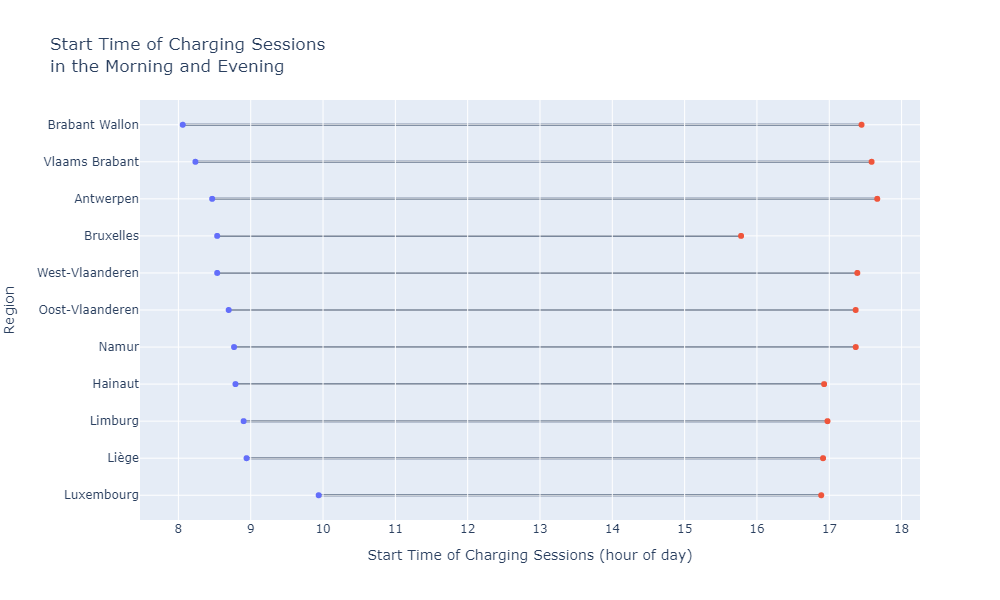

In [15]:
fig = px.scatter(
    df_sessions_regions.sort_values(by='start_time_seconds_morning', ascending=False),
    x=["start_time_seconds_morning", "start_time_seconds_evening" ],
    y="NAME_2",
    height=600, width=1000,
    title="Start Time of Charging Sessions<br>in the Morning and Evening",
    labels={"value": "Start Time of Charging Sessions (hour of day)", "NAME_2": "Region"},
)

fig.update_layout(
    showlegend=False,
    xaxis=dict(
        tickmode="array",
        tickvals=[
            0,
            3 * 3600,
            6 * 3600,
            7 * 3600,
            8 * 3600,
            9 * 3600,
            10 * 3600,
            11 * 3600,
            12 * 3600,
            13 * 3600,
            14 * 3600,
            15 * 3600,
            16 * 3600,
            17 * 3600,
            18 * 3600,
            19 * 3600,
            20 * 3600,
            21 * 3600,
            24 * 3600,
        ],
        ticktext=["0h", "3h", "6h", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19h", "20h", "21h", "24h"],
    )
)

# iterate on each region
for i in df_sessions_regions["NAME_2"].unique():
    # filter by region
    df_sub = df_sessions_regions[df_sessions_regions["NAME_2"] == i]
    
    y0=df_sub.NAME_2.values[0]    
    x0=df_sub.start_time_seconds_morning.values[0]
    y1=df_sub.NAME_2.values[0]
    x1=df_sub.start_time_seconds_evening.values[0]

    fig.add_shape(
        type="line",
        layer="below",
        # connect the two markers
        y0=df_sub.NAME_2.values[0],
        x0=df_sub.start_time_seconds_morning.values[0],
        y1=df_sub.NAME_2.values[0],
        x1=df_sub.start_time_seconds_evening.values[0],
    )

#fig.show()
# Instead of Plotly show() we can also take the bytes of the image and display it in the notebook directly using Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)